In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_Br

In [5]:
# Install segmentation-models library for easy U-Net implementation with custom backbones
!pip install -U segmentation-models

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [6]:
# Import required libraries
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nibabel as nib

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [7]:
# Define constants and paths for dataset
IMG_SIZE = 128
VOLUME_SLICES = 100
VOLUME_START_AT = 22
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

# Define segmentation classes for labeling
SEGMENT_CLASSES = {
    0: 'Not Tumor',
    1: 'Necrotic/Core',
    2: 'Edema',
    3: 'Enhancing'
}

In [8]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dataset_path, batch_size=1, dim=(IMG_SIZE, IMG_SIZE), n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.dataset_path = dataset_path
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, len(SEGMENT_CLASSES)))

        for i, ID in enumerate(Batch_ids):
            flair = nib.load(os.path.join(self.dataset_path, f'{ID}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(self.dataset_path, f'{ID}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(self.dataset_path, f'{ID}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES*i, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES*i, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)
                Y[j + VOLUME_SLICES*i] = tf.image.resize(tf.one_hot(seg[:, :, j + VOLUME_START_AT], len(SEGMENT_CLASSES)), self.dim)

        return X/np.max(X), Y

In [10]:
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)
n_classes = len(SEGMENT_CLASSES)
activation = 'softmax'

# Build U-Net model with ResNet50 encoder
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True, input_shape=(IMG_SIZE, IMG_SIZE, 2))

# Compile model with custom metrics
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', dice_coef, precision, sensitivity, specificity])

In [11]:
# Install segmentation models library
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras

# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from segmentation_models import Unet
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

# Define constants
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
IMG_SIZE = 128
VOLUME_SLICES = 100
VOLUME_START_AT = 22

# Define segmentation classes
SEGMENT_CLASSES = {
    0: 'Not Tumor',
    1: 'Necrotic/Core',
    2: 'Edema',
    3: 'Enhancing'
}

# List all case IDs in the training dataset
list_of_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
print(f"Total cases found: {len(list_of_ids)}")

# Split the dataset into training and validation sets
train_ids, val_ids = train_test_split(list_of_ids, test_size=0.2, random_state=42)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dataset_path, batch_size=1, dim=(IMG_SIZE, IMG_SIZE), n_channels=3, shuffle=True):
        self.list_IDs = list_IDs
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, IMG_SIZE, IMG_SIZE, len(SEGMENT_CLASSES)))

        for i, case_id in enumerate(Batch_ids):
            flair_path = os.path.join(self.dataset_path, case_id, f"{case_id}_flair.nii")
            t1ce_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t1ce.nii")
            seg_path = os.path.join(self.dataset_path, case_id, f"{case_id}_seg.nii")

            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * i, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * i, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * i, :, :, 2] = 0  # Extra channel to match ResNet's 3-channel requirement
                seg_resized = cv2.resize(seg[:, :, j + VOLUME_START_AT], self.dim)
                y[j + VOLUME_SLICES * i] = tf.one_hot(seg_resized, len(SEGMENT_CLASSES))

        return X / np.max(X), y

# Initialize data generators
training_generator = DataGenerator(train_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=True)
validation_generator = DataGenerator(val_ids, VALIDATION_DATASET_PATH, batch_size=1, shuffle=False)

# Define the model using Unet with a ResNet backbone
BACKBONE = 'resnet50'
model = Unet(BACKBONE, classes=len(SEGMENT_CLASSES), activation='softmax', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=['accuracy', MeanIoU(num_classes=len(SEGMENT_CLASSES))]
)

# Set up callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    csv_logger
]

# Train the model
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=3,  # Change to more epochs for real training
    callbacks=callbacks
)

# Save the model
model.save("brain_tumor_segmentation_unet_resnet.h5")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


env: SM_FRAMEWORK=tf.keras
Total cases found: 369
94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731586216.548769     103 service.cc:145] XLA service 0x7af74c016fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731586216.548825     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731586256.700864     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/295 ━━━━━━━━━━━━━━━━━━━━ 2:07 752ms/step - accuracy: 0.9038 - loss: 0.3812 - mean_io_u: 0.2559

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: No such file or no access: '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/nibabel/loadsave.py", line 100, in load
    stat_result = os.stat(filename)

FileNotFoundError: [Errno 2] No such file or directory: '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 260, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 253, in generator_fn
    yield self.py_dataset[i]

  File "/tmp/ipykernel_30/2383759165.py", line 58, in __getitem__
    X, y = self.__data_generation(Batch_ids)

  File "/tmp/ipykernel_30/2383759165.py", line 77, in __data_generation
    seg = nib.load(seg_path).get_fdata()

  File "/opt/conda/lib/python3.10/site-packages/nibabel/loadsave.py", line 102, in load
    raise FileNotFoundError(f"No such file or no access: '{filename}'")

FileNotFoundError: No such file or no access: '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) UNKNOWN:  FileNotFoundError: No such file or no access: '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/nibabel/loadsave.py", line 100, in load
    stat_result = os.stat(filename)

FileNotFoundError: [Errno 2] No such file or directory: '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 260, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 253, in generator_fn
    yield self.py_dataset[i]

  File "/tmp/ipykernel_30/2383759165.py", line 58, in __getitem__
    X, y = self.__data_generation(Batch_ids)

  File "/tmp/ipykernel_30/2383759165.py", line 77, in __data_generation
    seg = nib.load(seg_path).get_fdata()

  File "/opt/conda/lib/python3.10/site-packages/nibabel/loadsave.py", line 102, in load
    raise FileNotFoundError(f"No such file or no access: '{filename}'")

FileNotFoundError: No such file or no access: '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_48196]

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau

In [9]:
import os
import numpy as np
import nibabel as nib
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from keras.callbacks import CSVLogger, ReduceLROnPlateau

# Define constants
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
IMG_SIZE = 128
VOLUME_SLICES = 100
VOLUME_START_AT = 22
SEGMENT_CLASSES = {0: 'Not Tumor', 1: 'Necrotic/Core', 2: 'Edema', 3: 'Enhancing'}

# List all case IDs and exclude missing files
all_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
valid_ids = [case_id for case_id in all_ids if os.path.exists(os.path.join(TRAIN_DATASET_PATH, case_id, f"{case_id}_seg.nii"))]

# Split the dataset
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(valid_ids, test_size=0.2, random_state=42)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dataset_path, batch_size=1, dim=(IMG_SIZE, IMG_SIZE), n_channels=3, shuffle=True):
        self.list_IDs = list_IDs
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, IMG_SIZE, IMG_SIZE, len(SEGMENT_CLASSES)))
        
        for i, case_id in enumerate(Batch_ids):
            flair_path = os.path.join(self.dataset_path, case_id, f"{case_id}_flair.nii")
            t1ce_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t1ce.nii")
            seg_path = os.path.join(self.dataset_path, case_id, f"{case_id}_seg.nii")

            if not os.path.exists(seg_path):
                print(f"Skipping missing file: {seg_path}")
                continue
            
            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * i, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * i, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * i, :, :, 2] = 0
                seg_resized = cv2.resize(seg[:, :, j + VOLUME_START_AT], self.dim)
                y[j + VOLUME_SLICES * i] = tf.one_hot(seg_resized, len(SEGMENT_CLASSES))

        return X / np.max(X), y

# Initialize data generators
training_generator = DataGenerator(train_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=True)
validation_generator = DataGenerator(val_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=False)

# Define model
BACKBONE = 'resnet50'
model = Unet(BACKBONE, classes=len(SEGMENT_CLASSES), activation='softmax', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=['accuracy', MeanIoU(num_classes=len(SEGMENT_CLASSES))]
)

# Set up callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1), csv_logger
]

# Train the model
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks
)

# Save the model
model.save("brain_tumor_segmentation_unet_resnet.h5")

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731655738.254850      99 service.cc:145] XLA service 0x7f80cc0033b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731655738.254935      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731655778.913207      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


294/294 ━━━━━━━━━━━━━━━━━━━━ 348s 925ms/step - accuracy: 0.9043 - loss: 0.3019 - mean_io_u: 0.2526 - val_accuracy: 0.9867 - val_loss: 0.0936 - val_mean_io_u: 0.2500 - learning_rate: 0.0010
Epoch 2/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 192s 646ms/step - accuracy: 0.9870 - loss: 0.0337 - mean_io_u: 0.2534 - val_accuracy: 0.9867 - val_loss: 0.1168 - val_mean_io_u: 0.2500 - learning_rate: 0.0010
Epoch 3/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9887 - loss: 0.0299 - mean_io_u: 0.2557
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
294/294 ━━━━━━━━━━━━━━━━━━━━ 192s 646ms/step - accuracy: 0.9887 - loss: 0.0299 - mean_io_u: 0.2557 - val_accuracy: 0.9867 - val_loss: 0.1122 - val_mean_io_u: 0.2503 - learning_rate: 0.0010
Epoch 4/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 193s 647ms/step - accuracy: 0.9888 - loss: 0.0286 - mean_io_u: 0.2525 - val_accuracy: 0.9812 - val_loss: 0.0996 - val_mean_io_u: 0.2500 - learning_rate: 2.0000e-04
Epoch 5/35
294/294 ━━━━━━━━━━━━━━

In [10]:
# Evaluate the model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]}")
print(f"Validation Accuracy: {results[1]}")
print(f"Mean IoU: {results[2]}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 373ms/step - accuracy: 0.9871 - loss: 0.0910 - mean_io_u: 0.2598
Validation Loss: 0.09364494681358337
Validation Accuracy: 0.9866799712181091
Mean IoU: 0.25


In [2]:
import os
import numpy as np
import nibabel as nib
import cv2
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# Define constants
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
IMG_SIZE = 128
VOLUME_SLICES = 100
VOLUME_START_AT = 22
SEGMENT_CLASSES = {0: 'Not Tumor', 1: 'Necrotic/Core', 2: 'Edema', 3: 'Enhancing'}

# List all case IDs and exclude missing files
all_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
valid_ids = [case_id for case_id in all_ids if os.path.exists(os.path.join(TRAIN_DATASET_PATH, case_id, f"{case_id}_seg.nii"))]

# Split the dataset
train_ids, val_ids = train_test_split(valid_ids, test_size=0.2, random_state=42)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dataset_path, batch_size=1, dim=(IMG_SIZE, IMG_SIZE), n_channels=3, shuffle=True):
        self.list_IDs = list_IDs
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, IMG_SIZE, IMG_SIZE, len(SEGMENT_CLASSES)))

        for i, case_id in enumerate(Batch_ids):
            flair_path = os.path.join(self.dataset_path, case_id, f"{case_id}_flair.nii")
            t1ce_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t1ce.nii")
            seg_path = os.path.join(self.dataset_path, case_id, f"{case_id}_seg.nii")

            if not os.path.exists(seg_path):
                print(f"Skipping missing file: {seg_path}")
                continue

            # Load image and segmentation data
            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                # Resize images
                flair_slice = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_LINEAR)
                t1ce_slice = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_LINEAR)

                X[j + VOLUME_SLICES * i, :, :, 0] = flair_slice
                X[j + VOLUME_SLICES * i, :, :, 1] = t1ce_slice
                X[j + VOLUME_SLICES * i, :, :, 2] = 0  # Placeholder for third channel

                # Process segmentation mask
                seg_slice = seg[:, :, j + VOLUME_START_AT]
                seg_resized = cv2.resize(seg_slice, self.dim, interpolation=cv2.INTER_NEAREST)

                # Map label 4 to 3 to match SEGMENT_CLASSES
                seg_resized[seg_resized == 4] = 3
                seg_resized = seg_resized.astype(np.uint8)

                # One-hot encode segmentation mask
                y[j + VOLUME_SLICES * i] = tf.one_hot(seg_resized, len(SEGMENT_CLASSES))

        # Normalize images
        X = X / (np.max(X) + 1e-8)

        return X, y

# Initialize data generators
training_generator = DataGenerator(train_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=True)
validation_generator = DataGenerator(val_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=False)

# Define model
BACKBONE = 'resnet50'
model = Unet(BACKBONE, classes=len(SEGMENT_CLASSES), activation='softmax', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', MeanIoU(num_classes=len(SEGMENT_CLASSES))]
)

# Set up callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    csv_logger
]

# Train the model
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks
)

# Save the model
model.save("brain_tumor_segmentation_unet_resnet.h5")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7d2145f1be20>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


ModuleNotFoundError: No module named 'segmentation_models'

In [29]:
# Evaluate the model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]}")
print(f"Validation Accuracy: {results[1]}")
print(f"Mean IoU: {results[2]}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 29s 388ms/step - accuracy: 0.9718 - loss: 0.0843 - mean_io_u_9: 0.2598
Validation Loss: 0.08064184337854385
Validation Accuracy: 0.9741050601005554
Mean IoU: 0.25


In [31]:
import os
import numpy as np
import nibabel as nib
import cv2
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import segmentation_models as sm

# Define constants
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
IMG_SIZE = 128
VOLUME_SLICES = 100
VOLUME_START_AT = 22
SEGMENT_CLASSES = {0: 'Not Tumor', 1: 'Necrotic/Core', 2: 'Edema', 3: 'Enhancing'}

# List all case IDs and exclude missing files
all_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
valid_ids = [case_id for case_id in all_ids if os.path.exists(os.path.join(TRAIN_DATASET_PATH, case_id, f"{case_id}_seg.nii"))]

# Split the dataset
train_ids, val_ids = train_test_split(valid_ids, test_size=0.2, random_state=42)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dataset_path, batch_size=1, dim=(IMG_SIZE, IMG_SIZE), n_channels=3, shuffle=True):
        self.list_IDs = list_IDs
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels  # Set to 3 channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size * VOLUME_SLICES, IMG_SIZE, IMG_SIZE), dtype=np.uint8)

        for i, case_id in enumerate(Batch_ids):
            flair_path = os.path.join(self.dataset_path, case_id, f"{case_id}_flair.nii")
            t1ce_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t1ce.nii")
            # Optionally include T2 modality if available
            # t2_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t2.nii")
            seg_path = os.path.join(self.dataset_path, case_id, f"{case_id}_seg.nii")

            if not os.path.exists(seg_path):
                print(f"Skipping missing file: {seg_path}")
                continue

            # Load image and segmentation data
            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            # t2 = nib.load(t2_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                # Resize images
                flair_slice = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_LINEAR)
                t1ce_slice = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_LINEAR)
                # t2_slice = cv2.resize(t2[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_LINEAR)

                # Normalize each slice
                flair_slice = (flair_slice - np.min(flair_slice)) / (np.max(flair_slice) - np.min(flair_slice) + 1e-8)
                t1ce_slice = (t1ce_slice - np.min(t1ce_slice)) / (np.max(t1ce_slice) - np.min(t1ce_slice) + 1e-8)
                # t2_slice = (t2_slice - np.min(t2_slice)) / (np.max(t2_slice) - np.min(t2_slice) + 1e-8)

                X[j + VOLUME_SLICES * i, :, :, 0] = flair_slice
                X[j + VOLUME_SLICES * i, :, :, 1] = t1ce_slice
                # Include t2_slice if available
                # X[j + VOLUME_SLICES * i, :, :, 2] = t2_slice

                # Option 1: Set third channel to zeros if no t2 modality
                X[j + VOLUME_SLICES * i, :, :, 2] = 0.0

                # Option 2: Duplicate one of the channels (e.g., t1ce_slice)
                # X[j + VOLUME_SLICES * i, :, :, 2] = t1ce_slice

                # Process segmentation mask
                seg_slice = seg[:, :, j + VOLUME_START_AT]
                seg_resized = cv2.resize(seg_slice, self.dim, interpolation=cv2.INTER_NEAREST)

                # Map label 4 to 3
                seg_resized[seg_resized == 4] = 3
                seg_resized = seg_resized.astype(np.uint8)

                y[j + VOLUME_SLICES * i] = seg_resized

        # One-hot encode segmentation masks
        y_one_hot = tf.one_hot(y, depth=len(SEGMENT_CLASSES), axis=-1)

        return X, y_one_hot

# Define custom Mean IoU metric
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions and labels to integer format
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Initialize data generators
training_generator = DataGenerator(train_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=True)
validation_generator = DataGenerator(val_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=False)

# Define model
BACKBONE = 'resnet50'
model = Unet(
    backbone_name=BACKBONE,
    classes=len(SEGMENT_CLASSES),
    activation='softmax',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)  # Updated to 3 channels
)

# Define Dice Loss with class weights
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.1, 0.3, 0.3, 0.3]))

# Define custom Mean IoU metric
custom_mean_iou = CustomMeanIoU(num_classes=len(SEGMENT_CLASSES))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=['accuracy', custom_mean_iou]
)

# Set up callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    csv_logger
]

# Train the model
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks
)

# Save the model
model.save("brain_tumor_segmentation_unet_resnet.h5")

Epoch 1/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 155s 353ms/step - accuracy: 0.9166 - custom_mean_io_u: 0.2167 - loss: 0.9357 - val_accuracy: 0.9844 - val_custom_mean_io_u: 0.2247 - val_loss: 0.9752 - learning_rate: 0.0010
Epoch 2/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 98s 329ms/step - accuracy: 0.9871 - custom_mean_io_u: 0.4821 - loss: 0.8744 - val_accuracy: 0.9844 - val_custom_mean_io_u: 0.2247 - val_loss: 0.9752 - learning_rate: 0.0010
Epoch 3/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9901 - custom_mean_io_u: 0.5500 - loss: 0.8547
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
294/294 ━━━━━━━━━━━━━━━━━━━━ 99s 331ms/step - accuracy: 0.9901 - custom_mean_io_u: 0.5499 - loss: 0.8547 - val_accuracy: 0.9844 - val_custom_mean_io_u: 0.2247 - val_loss: 0.9752 - learning_rate: 0.0010
Epoch 4/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 142s 331ms/step - accuracy: 0.9911 - custom_mean_io_u: 0.5781 - loss: 0.8443 - val_accuracy: 0.9913 - val_custom_mean_io_u: 0.5283 - val_lo

In [12]:
import os
import numpy as np
import nibabel as nib
import cv2
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import segmentation_models as sm

# Define constants
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
IMG_SIZE = 128
VOLUME_SLICES = 100
VOLUME_START_AT = 22
SEGMENT_CLASSES = {0: 'Not Tumor', 1: 'Necrotic/Core', 2: 'Edema', 3: 'Enhancing'}

# List all case IDs and exclude missing files
all_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
valid_ids = [case_id for case_id in all_ids if os.path.exists(os.path.join(TRAIN_DATASET_PATH, case_id, f"{case_id}_seg.nii"))]

# Split the dataset
train_ids, val_ids = train_test_split(valid_ids, test_size=0.2, random_state=42)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dataset_path, batch_size=1, dim=(IMG_SIZE, IMG_SIZE), n_channels=3, shuffle=True):
        self.list_IDs = list_IDs
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels  # Set to 3 channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size * VOLUME_SLICES, IMG_SIZE, IMG_SIZE), dtype=np.uint8)

        for i, case_id in enumerate(Batch_ids):
            flair_path = os.path.join(self.dataset_path, case_id, f"{case_id}_flair.nii")
            t1ce_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t1ce.nii")
            # Optionally include T2 modality if available
            # t2_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t2.nii")
            seg_path = os.path.join(self.dataset_path, case_id, f"{case_id}_seg.nii")

            if not os.path.exists(seg_path):
                print(f"Skipping missing file: {seg_path}")
                continue

            # Load image and segmentation data
            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            # t2 = nib.load(t2_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                # Resize images
                flair_slice = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_LINEAR)
                t1ce_slice = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_LINEAR)
                # t2_slice = cv2.resize(t2[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_LINEAR)

                # Normalize each slice
                flair_slice = (flair_slice - np.min(flair_slice)) / (np.max(flair_slice) - np.min(flair_slice) + 1e-8)
                t1ce_slice = (t1ce_slice - np.min(t1ce_slice)) / (np.max(t1ce_slice) - np.min(t1ce_slice) + 1e-8)
                # t2_slice = (t2_slice - np.min(t2_slice)) / (np.max(t2_slice) - np.min(t2_slice) + 1e-8)

                X[j + VOLUME_SLICES * i, :, :, 0] = flair_slice
                X[j + VOLUME_SLICES * i, :, :, 1] = t1ce_slice
                # Include t2_slice if available
                # X[j + VOLUME_SLICES * i, :, :, 2] = t2_slice

                # Option 1: Set third channel to zeros if no t2 modality
                X[j + VOLUME_SLICES * i, :, :, 2] = 0.0

                # Option 2: Duplicate one of the channels (e.g., t1ce_slice)
                # X[j + VOLUME_SLICES * i, :, :, 2] = t1ce_slice

                # Process segmentation mask
                seg_slice = seg[:, :, j + VOLUME_START_AT]
                seg_resized = cv2.resize(seg_slice, self.dim, interpolation=cv2.INTER_NEAREST)

                # Map label 4 to 3
                seg_resized[seg_resized == 4] = 3
                seg_resized = seg_resized.astype(np.uint8)

                y[j + VOLUME_SLICES * i] = seg_resized

        # One-hot encode segmentation masks
        y_one_hot = tf.one_hot(y, depth=len(SEGMENT_CLASSES), axis=-1)

        return X, y_one_hot

# Define custom Mean IoU metric
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions and labels to integer format
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Initialize data generators
training_generator = DataGenerator(train_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=True)
validation_generator = DataGenerator(val_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=False)

# Define model
BACKBONE = 'resnet50'
model = Unet(
    backbone_name=BACKBONE,
    classes=len(SEGMENT_CLASSES),
    activation='softmax',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)  # Updated to 3 channels
)

# Define Dice Loss with class weights
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.1, 0.3, 0.3, 0.3]))

# Define custom Mean IoU metric
custom_mean_iou = CustomMeanIoU(num_classes=len(SEGMENT_CLASSES))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=['accuracy', custom_mean_iou]
)

# Set up callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    csv_logger
]

# Train the model
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks
)

# Save the model
model.save("brain_tumor_segmentation_unet_resnet.h5")

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731669081.576776     106 service.cc:145] XLA service 0x7d1fd4016c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731669081.576833     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731669121.579798     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


294/294 ━━━━━━━━━━━━━━━━━━━━ 284s 714ms/step - accuracy: 0.9230 - custom_mean_io_u: 0.2312 - loss: 0.9354 - val_accuracy: 0.9844 - val_custom_mean_io_u: 0.2247 - val_loss: 0.9752 - learning_rate: 0.0010
Epoch 2/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 99s 332ms/step - accuracy: 0.9889 - custom_mean_io_u: 0.5185 - loss: 0.8642 - val_accuracy: 0.9844 - val_custom_mean_io_u: 0.2247 - val_loss: 0.9752 - learning_rate: 0.0010
Epoch 3/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 100s 334ms/step - accuracy: 0.9900 - custom_mean_io_u: 0.5578 - loss: 0.8511 - val_accuracy: 0.9846 - val_custom_mean_io_u: 0.2456 - val_loss: 0.9635 - learning_rate: 0.0010
Epoch 4/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 99s 330ms/step - accuracy: 0.9911 - custom_mean_io_u: 0.5801 - loss: 0.8484 - val_accuracy: 0.9902 - val_custom_mean_io_u: 0.5168 - val_loss: 0.8773 - learning_rate: 0.0010
Epoch 5/35
294/294 ━━━━━━━━━━━━━━━━━━━━ 98s 330ms/step - accuracy: 0.9917 - custom_mean_io_u: 0.6079 - loss: 0.8408 - val_accuracy: 0.9921 - val_custom_mean_

In [13]:
# Evaluate the model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]}")
print(f"Validation Accuracy: {results[1]}")
print(f"Mean IoU: {results[2]}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.9940 - custom_mean_io_u: 0.6551 - loss: 0.8330
Validation Loss: 0.8381668329238892
Validation Accuracy: 0.9935060739517212
Mean IoU: 0.6435649394989014


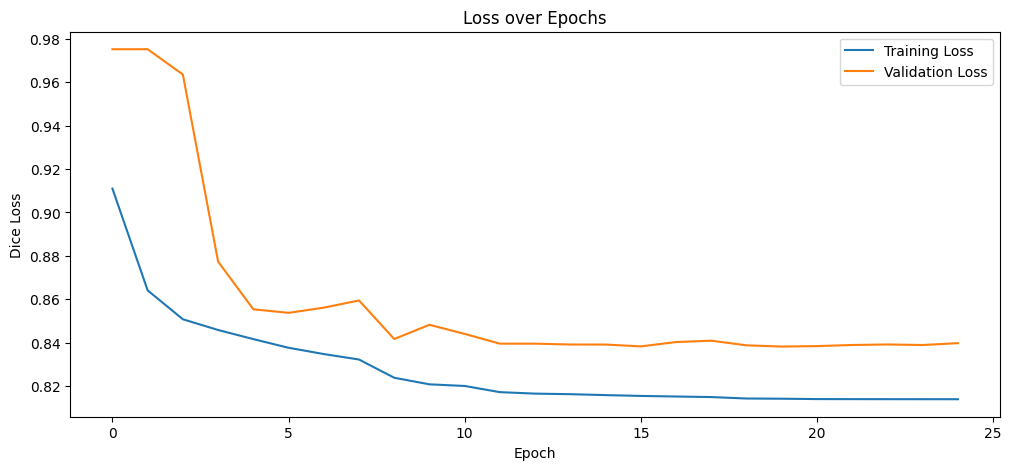

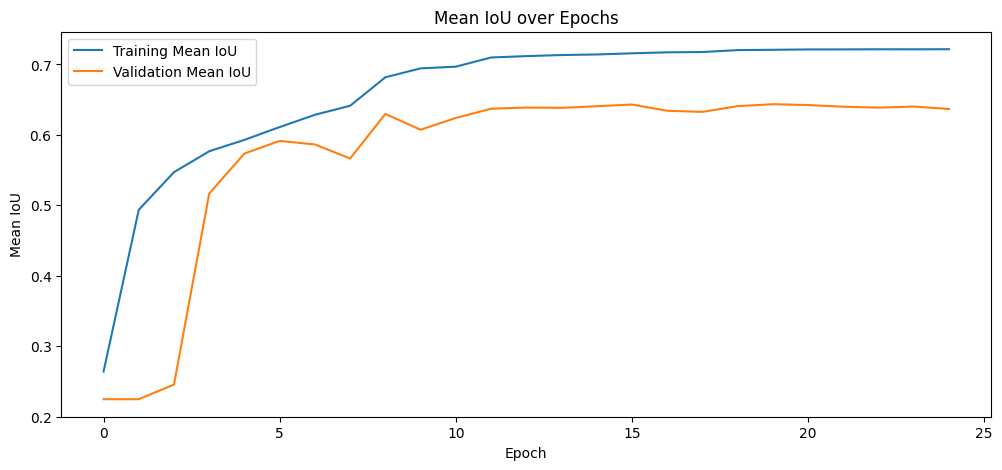

In [14]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()

# Plot Mean IoU
plt.figure(figsize=(12, 5))
plt.plot(history.history['custom_mean_io_u'], label='Training Mean IoU')
plt.plot(history.history['val_custom_mean_io_u'], label='Validation Mean IoU')
plt.title('Mean IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()
